<a href="https://colab.research.google.com/github/DasilvaCatarina/-gest-o-de-aluguer-de-im-veis/blob/main/Gest%C3%A3o_aluger_imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sistema de Gestão de Aluguer de Imóveis**
Realizado por:

-Catarina  Silva

-Ana Martins

-Daniel Teixeira da Silva

-João Pedro Pinto Costa


Logbook:https://docs.google.com/document/d/1ARa5t2Dxl0LvPMn40caitLQuUNPLj3jOobCxl6A-NW8/edit?usp=sharing

Este código tem como objetivo a implementação de um sistema de gerenciamento de alugueres de imóveis, permitindo:
- Cadastro de clientes;
- Cadastro de imóveis disponíveis para aluguel;
- Reserva de imóveis para um período específico;
- Cálculo automático do custo da reserva;
- Visualização da faturação total e por imóvel com gráficos.

O sistema gerencia as reservas, garantindo que um imóvel não seja reservado para o mesmo período duas vezes.





In [ ]:
import re
import datetime
from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from datetime import timedelta

### **Estrutura do Sistema**

Este sistema gerencia aluguéis de imóveis, organizando clientes, reservas e faturamento.

- **Cliente**: Representa uma pessoa que pode alugar um imóvel, armazenando nome, email, telefone e reservas associadas.  
- **Imóvel**: Define as propriedades disponíveis para aluguel, incluindo localização, preço por noite e um método para verificar disponibilidade.  
- **Reserva**: Registra o período de aluguel de um imóvel por um cliente, garantindo que não haja conflitos de datas e calculando o custo total com base na estadia.  
- **GestorAluguer**: Gerencia o cadastro de clientes e imóveis, permite a criação de reservas e fornece um relatório financeiro da faturação total.




In [ ]:
class Cliente:
    def __init__(self, nome, email, telefone, nif):
        self.nif = nif  # Usamos o NIF como ID
        self.nome = nome
        self.email = email
        self.telefone = telefone
        self.contratos = []

    def adicionar_contrato(self, contrato):
        self.contratos.append(contrato)

    def __str__(self):
        return f"{self.nome} ({self.nif}) - {self.email} - {self.telefone}"

class Imovel:
    def __init__(self, localizacao, preco_noite, descricao):
        self.id = f"{localizacao} - {descricao}"  # Utiliza a chave como ID
        self.localizacao = localizacao
        self.preco_noite = preco_noite
        self.descricao = descricao
        self.reservas = []

    def chave(self):
        return f"{self.localizacao} - {self.descricao}"

    def adicionar_reserva(self, reserva):
        self.reservas.append(reserva)

    def esta_disponivel(self, data_inicio, data_fim):
        for reserva in self.reservas:
            if not (data_fim <= reserva.data_inicio or data_inicio >= reserva.data_fim):
                return False
        return True

    def __str__(self):
        return f"{self.localizacao} - {self.descricao} - {self.preco_noite}€/noite"

class Reserva:
    def __init__(self, cliente, imovel, data_inicio, data_fim):
        self.cliente = cliente
        self.imovel = imovel
        self.data_inicio = data_inicio
        self.data_fim = data_fim
        self.custo = self.calcular_custo()
        cliente.adicionar_contrato(self)
        imovel.adicionar_reserva(self)

    def calcular_custo(self):
        noites = (self.data_fim - self.data_inicio).days
        return noites * self.imovel.preco_noite

    def __str__(self):
        return f"Reserva de {self.cliente.nome} em {self.imovel.descricao} ({self.imovel.localizacao}) de {self.data_inicio} a {self.data_fim}, custo: {self.custo}€"

class GestorAluguer:
    def __init__(self):
        self.clientes = []
        self.imoveis = []
        self.reservas = []

    def adicionar_cliente(self, nome, email, telefone, nif):
        if any(c.nif == nif for c in self.clientes):
            print(f"Erro: Já existe um cliente com NIF {nif}.")
            return None
        cliente = Cliente(nome, email, telefone, nif)
        self.clientes.append(cliente)
        return cliente

    def adicionar_imovel(self, localizacao, preco_noite, descricao):
        chave = f"{localizacao} - {descricao}"
        if any(i.chave() == chave for i in self.imoveis):
            print(f"Erro: Já existe um imóvel com a chave '{chave}'.")
            return None
        imovel = Imovel(localizacao, preco_noite, descricao)
        self.imoveis.append(imovel)
        return imovel

    def listar_clientes(self):
        if not self.clientes:
            print("Nenhum cliente registado.")
            return
        df = pd.DataFrame([{
            "NIF": c.nif,
            "Nome": c.nome,
            "Email": c.email,
            "Telefone": c.telefone
        } for c in self.clientes])
        df = df.sort_values(by="Nome")
        print("\nClientes registados:")
        print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

    def listar_imoveis(self):
        if not self.imoveis:
            print("Nenhum imóvel registado.")
            return
        df = pd.DataFrame([{
            "ID": i.id,
            "Descrição": i.descricao,
            "Localização": i.localizacao,
            "Preço/Noite (€)": i.preco_noite
        } for i in self.imoveis])
        df = df.sort_values(by="Preço/Noite (€)")
        print("\nImóveis disponíveis:")
        print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))


    def listar_reservas(self):
        if not self.reservas:
            print("Não há reservas feitas.")
            return

        # Criar um DataFrame com as reservas
        df = pd.DataFrame([{
            "Cliente": r.cliente.nome,
            "Imóvel": r.imovel.descricao,
            "Localização": r.imovel.localizacao,
            "Data Início": r.data_inicio,
            "Data Fim": r.data_fim,
            "Custo (€)": r.custo
        } for r in self.reservas])

        # Ordenar as reservas por Data de Início
        df = df.sort_values(by="Data Início")

        # Exibir a tabela
        print("\nReservas realizadas:")
        print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))


    def criar_reserva(self, email_cliente, chave_imovel, data_inicio, data_fim):
        cliente = next((c for c in self.clientes if c.email == email_cliente), None)
        imovel = next((i for i in self.imoveis if i.chave() == chave_imovel), None)

        if not cliente:
            print(f"Erro: Cliente com e-mail '{email_cliente}' não encontrado.")
            return None
        if not imovel:
            print(f"Erro: Imóvel com chave '{chave_imovel}' não encontrado.")
            return None

        if imovel.esta_disponivel(data_inicio, data_fim):
            reserva = Reserva(cliente, imovel, data_inicio, data_fim)
            self.reservas.append(reserva)
            print("Reserva criada com sucesso.")
            return reserva
        else:
            print("Erro: O imóvel já está reservado nesse período.")
            return None

    def validar_integridade_dados(self):
        erros = []

        # Validação de clientes
        nifs = set()
        for cliente in self.clientes:
            if cliente.nif in nifs:
                erros.append(f"Cliente duplicado: {cliente.nif}")
            nifs.add(cliente.nif)

        # Validação de imóveis
        descricoes = set()
        for imovel in self.imoveis:
            chave = imovel.chave()
            if chave in descricoes:
                erros.append(f"Imóvel duplicado: {chave}")
            descricoes.add(chave)

        # Validação de reservas
        for reserva in self.reservas:
            if reserva.cliente not in self.clientes:
                erros.append(f"Reserva com cliente inexistente: {reserva.cliente.nif}")
            if reserva.imovel not in self.imoveis:
                erros.append(f"Reserva com imóvel inexistente: {reserva.imovel.localizacao} - {reserva.imovel.descricao}")
            if reserva.data_fim <= reserva.data_inicio:
                erros.append(f"Reserva com datas inválidas: {reserva}")
            for outra in reserva.imovel.reservas:
                if outra == reserva:
                    continue
                if not (reserva.data_fim <= outra.data_inicio or reserva.data_inicio >= outra.data_fim):
                    erros.append(f"Reserva em conflito: {reserva} colide com {outra}")

        if not erros:
            print("✅ Todos os dados estão consistentes.")
        else:
            print("⚠️ Problemas de integridade encontrados:")
            for erro in erros:
                print(" -", erro)

    def melhor_cliente(self):
        if not self.reservas:
            print("Não há reservas para analisar.")
            return None

        faturacao_por_cliente = defaultdict(float)
        for reserva in self.reservas:
            faturacao_por_cliente[reserva.cliente.nif] += reserva.custo

        melhor_nif = max(faturacao_por_cliente, key=faturacao_por_cliente.get)
        total = faturacao_por_cliente[melhor_nif]
        cliente = next(c for c in self.clientes if c.nif == melhor_nif)

        print(f"Melhor cliente: {cliente.nome} ({cliente.nif})")
        print(f"Total faturado: {total}€")

        return cliente, total

    def imovel_top_faturacao(self):
        if not self.reservas:
            print("Sem reservas para analisar.")
            return None

        faturacao_por_imovel = defaultdict(float)
        for reserva in self.reservas:
            chave = reserva.imovel.chave()
            faturacao_por_imovel[chave] += reserva.custo

        imovel_top = max(faturacao_por_imovel, key=faturacao_por_imovel.get)
        total = faturacao_por_imovel[imovel_top]

        print(f"Imóvel mais lucrativo: {imovel_top}")
        print(f"Faturação total: {total}€")

        return imovel_top, total

    def mes_mais_procurado(self):
        if not self.reservas:
            print("Sem reservas para analisar.")
            return None

        ocupacao_por_mes = defaultdict(int)
        for reserva in self.reservas:
            data = reserva.data_inicio
            while data < reserva.data_fim:
                mes_ano = (data.year, data.month)
                ocupacao_por_mes[mes_ano] += 1
                data += datetime.timedelta(days=1)

        max_ocupacao = max(ocupacao_por_mes.values())
        meses_mais_movimentados = [
            mes for mes, dias in ocupacao_por_mes.items() if dias == max_ocupacao
        ]

        for ano, mes in meses_mais_movimentados:
            print(f"Mês mais procurado: {mes:02d}/{ano} com {max_ocupacao} dias de ocupação")

        return meses_mais_movimentados, max_ocupacao

    def relatorio_periodo(self, data_inicio, data_fim):
        reservas_no_periodo = [
            r for r in self.reservas if r.data_inicio <= data_fim and r.data_fim >= data_inicio
        ]
        total_reservas = len(reservas_no_periodo)
        total_faturado = sum(r.custo for r in reservas_no_periodo)

        if reservas_no_periodo:
            df = pd.DataFrame([{
                "Cliente": r.cliente.nome,
                "Imóvel": r.imovel.descricao,
                "Localização": r.imovel.localizacao,
                "Data Início": r.data_inicio,
                "Data Fim": r.data_fim,
                "Custo (€)": r.custo
            } for r in reservas_no_periodo])
            df = df.sort_values(by="Data Início")
            print("\nReservas no período:")
            print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

        print(f"Relatório de {data_inicio} a {data_fim}")
        print(f"Total de reservas: {total_reservas}")
        print(f"Total faturado: {total_faturado}€")

        return total_reservas, total_faturado

    def visualizar_faturacao(self):
        data = defaultdict(float)
        for imovel in self.imoveis:
            chave = imovel.chave()
            data[chave] += sum(r.custo for r in imovel.reservas)

        df = pd.DataFrame(list(data.items()), columns=["Imóvel", "Faturação (€)"])
        df = df.sort_values(by="Faturação (€)", ascending=False)

        plt.figure(figsize=(10, 5))
        plt.bar(df["Imóvel"], df["Faturação (€)"], color='skyblue')
        plt.xlabel("Imóveis")
        plt.ylabel("Faturação (€)")
        plt.title("Faturação por Imóvel")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


In [ ]:
# Criar um sistema de clientes e imoveis e  demonstrar
gestor = GestorAluguer()

In [ ]:
# Adicionar clientes
gestor.adicionar_cliente("João Silva", "joao@email.com", "912345678","277888999")
gestor.adicionar_cliente("João Teixeira", "joaot@email.com", "912349678","277888910")
#Teste repetição do nif
gestor.adicionar_cliente("Ana Costa", "ana@email.com", "923456789","277888999")
gestor.adicionar_cliente("Ana Costa", "ana@email.com", "923456789","277888998")

# Adicionar imóveis
gestor.adicionar_imovel("Porto", 80, "Apartamento no centro")
gestor.adicionar_imovel("Lisboa", 120, "Apartamento com vista para o rio")
gestor.adicionar_imovel("Lisboa", 220, "Apartamento moderno com varanda")
#Teste repetição da descrição
gestor.adicionar_imovel("Lisboa", 120, "Apartamento moderno com varanda")

#teste de datas para o relatório do mês
data_inicio = datetime.date(2025, 4, 1)
data_fim = datetime.date(2025, 4, 30)



Erro: Já existe um cliente com NIF 277888999.
Erro: Já existe um imóvel com a chave 'Lisboa - Apartamento moderno com varanda'.


In [ ]:
#criação de reservas
gestor.criar_reserva("joao@email.com", "Porto - Apartamento no centro", datetime.date(2025, 4, 10), datetime.date(2025, 4, 15))
gestor.criar_reserva("ana@email.com", "Lisboa - Apartamento com vista para o rio", datetime.date(2025, 5, 11), datetime.date(2025, 5, 14))
gestor.criar_reserva("joao@email.com", "Lisboa - Apartamento com vista para o rio", datetime.date(2025, 5, 11), datetime.date(2025, 5, 14))
gestor.criar_reserva("joao@email.com", "Lisboa - Apartamento com vista para o rio", datetime.date(2025, 5, 20), datetime.date(2025, 5, 23))


# Testar conflito de datas
gestor.criar_reserva("joaot@email.com", "Lisboa - Apartamento moderno com varanda", datetime.date(2025, 4, 11), datetime.date(2025, 4, 14))
gestor.criar_reserva("joaot@email.com", "Lisboa - Apartamento com vista para o rio", datetime.date(2025, 5, 12), datetime.date(2025, 5, 13))

Reserva criada com sucesso.
Reserva criada com sucesso.
Erro: O imóvel já está reservado nesse período.
Reserva criada com sucesso.
Reserva criada com sucesso.
Erro: O imóvel já está reservado nesse período.


✅ Todos os dados estão consistentes.

Clientes registados:
╒═══════════╤═══════════════╤═════════════════╤════════════╕
│       NIF │ Nome          │ Email           │   Telefone │
╞═══════════╪═══════════════╪═════════════════╪════════════╡
│ 277888998 │ Ana Costa     │ ana@email.com   │  923456789 │
├───────────┼───────────────┼─────────────────┼────────────┤
│ 277888999 │ João Silva    │ joao@email.com  │  912345678 │
├───────────┼───────────────┼─────────────────┼────────────┤
│ 277888910 │ João Teixeira │ joaot@email.com │  912349678 │
╘═══════════╧═══════════════╧═════════════════╧════════════╛

Imóveis disponíveis:
╒═══════════════════════════════════════════╤══════════════════════════════════╤═══════════════╤═══════════════════╕
│ ID                                        │ Descrição                        │ Localização   │   Preço/Noite (€) │
╞═══════════════════════════════════════════╪══════════════════════════════════╪═══════════════╪═══════════════════╡
│ Porto - Apartamen

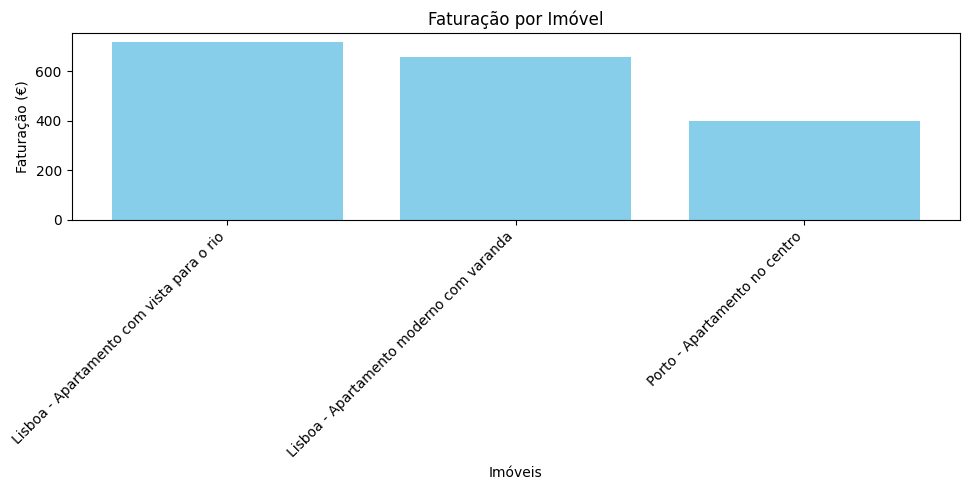

In [ ]:
# Mostrar gráficos
gestor.validar_integridade_dados()
gestor.listar_clientes()
gestor.listar_imoveis()
gestor.listar_reservas()
gestor.melhor_cliente()
gestor.imovel_top_faturacao()
gestor.mes_mais_procurado()
gestor.relatorio_periodo(data_inicio, data_fim)
gestor.visualizar_faturacao()